In [1]:
import os, re
import random, math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
from sklearn.model_selection import train_test_split
warnings.filterwarnings(action='ignore')

먼저 프로젝트를 동작하기 위해 필요한 패키지들을 import해오자.

In [2]:

AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [180, 180]


ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'


BATCH_SIZE = 16
EPOCHS = 40

print(ROOT_PATH)

/aiffel/aiffel


aututune을 이용해서 데이터를 로드할 때 더 빠르게 할 수 있도록 설정해준다.
그 다음 이미지 사이즈를 180,180으로 지정하고 x ray 데이터의 경로 변수를 설정해준다.
학습횟수도 25회 하려고 했는데 그렇게 하면 밑에서 accuracy 값이 75에서 89까지 왔다갔다 한다. 
여기서 횟수를 늘리면 시간은 오래 걸려도 accuracy값이 무조건 85퍼 이상은 되지 않을까? 그래서 이번에 35회로 돌려보았다.

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


위에서 import한 데이터를 가져와 본 다음 열어보면 test, train, val로 이미 나눠져 있다.
각각 데이터의 갯수는 총 몇개가 나올까?
그래서 위의 명령어를 하고 출력을 해보면 train 5216, test 624, val 16개가 나왔다.

In [4]:

filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))


train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


그런데 다른 데이터들보다 val의 수가 압도적으로 적다.
그러니 가장 데이터가 많은 train에서 val쪽으로 가져오기 위해 val과 train데이터를 합친다.
그 다음 합친 데이터를 8:2 비율로 나눠주면 train의 수는 약간 줄겠지만 val의 수는 확실히 많이 증가되어 있다.
train_size라인에 (*0.8)이 부분을 원하는 숫자로 바꾸면 비율을 바꿀 수 있는거 같다.

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


위에 normal과 pneumonia를 확이하면 정상과 폐렴 이미지를 셀 수 있다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


위에 정상폐와 폐렴폐의 이미지를 세봤는데 정상보다 폐렴이 3배정도 더 많이 출력되었다.
아직 딱히 훈련도 안되거라서 그런가 보다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


train과 val의 데이터 수를 확인해보면 아까 위에서 데이터 나눈 비율과 똑같이 나온다.
만진게 없으니 똑같이 나오나보다.

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

그런데 이미지에 따로 라벨이 되어있지는 않다.
그런데 경로에는 nomal이나 pneumonia가 이미 포함되어 있기 때문에 이거를 이용해서
라벨을 붙이는 함수를 이용해보았다.

In [9]:

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.resize(img, IMAGE_SIZE) 
    return img


def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path) 
    img = decode_img(img) 
    return img, label

이미지 데이터는 사이즈가 각기 다를 수 있다고 한다.
그러니 이미지 사이즈를 통일 시킬겸 사이즈도 줄여서 gpu 메모리를 더 효율적으로 사용할 수 있게 해보자.
먼저 나온 decode_img로 이미지의 타입과 사이즈를 변경시켜주고
process_path로 이미지를 읽어올 수 있다.

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

train 데이터 셋과 val 데이터셋을 만들어 num_parallel_calls에 autotune변수를 이용해서
더 빠르게 데이터를 처리할 수 있다.
=>이거 데이터 셋 만든거에 위에 오토튠으로 바꾼 이미지 데이터를 넣는다는 의미인가?

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


이미지가 제대로 사이즈가 맞는지 라벨이 제대로 붙어있는지 확인해보면
잘 되었다.

In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds_bs = prepare_for_training(train_ds)
val_ds_bs = prepare_for_training(val_ds)

tf.data 파이프 라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있다고하는데 어떤건지 잘 모르겠다.
tf.data를 이용해서 prepare_for_training()함수를 정의해 데이터를 변환시켜 주겠다고 한다.
그나마 알겠는 shuffle()을 이용해서 크기 버퍼를 유지하고 그 안에 버퍼에서 무작위로 균일하게 다른 요소를 선택
repeat()을 사용하면 epoch를 진행하면서 여러 번 데이터 셋을 불러오게 되는데, 여기서 repeat()를 사용한
데이터셋은 여러 번 데이터셋을 사용하게 해 준다고 한다.
batch()는 BATCH_SIZE에서 정해진 만큼의 배치로 주어진다.
prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 gpu에서 학습하는 동안 두번째 데이터를 cpu에서 준비 할 수 
있어 리소스의 유휴 상태를 줄일 수 있다고 한다.
[이부분이 처음보는 부분이라 그런지 어렵다]
여기서 기본은 뒤에_bs로 따로 붙여줬다 안붙여줬더니 밑에 argument에서 에러가 떠서 고생했다.

In [14]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training_aug(train_ds)
val_aug_ds = prepare_for_training_aug(val_ds)

------------------------------------------------------------------------------------------------------------------------------------------
여기까지 데이터 셋을 했으면 이제는 데이터를 시각화 해보는 단계이다.

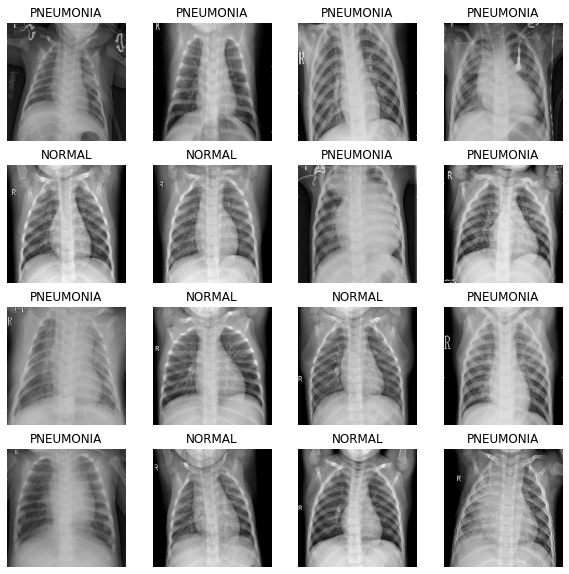

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds_bs))
show_batch(image_batch.numpy(), label_batch.numpy())

데이터를 보기 위해 먼저, 위에서 했던 train batch 중 첫 번째 배치를 추출한다.
그 다음 추출한 배치를 이미지와 라벨 데이터 셋으로 나눈 후 show_batch로 결과 사진을 확인 할 수 있다.
[여기서는 print를 안쓰고 show_batch를 쓰네]

(16, 180, 180, 3)
(16,)


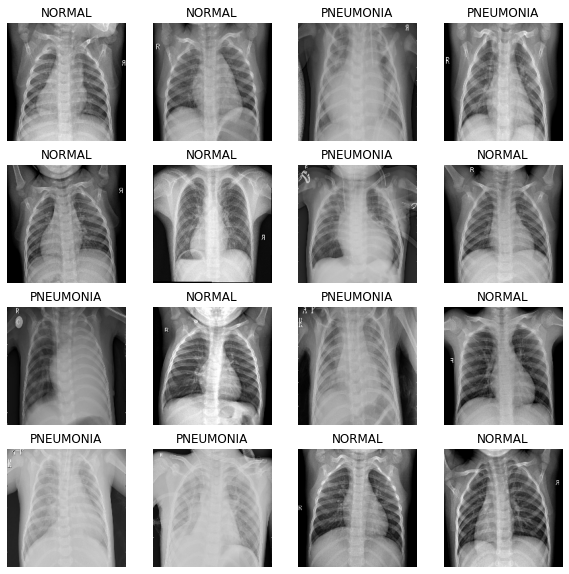

In [16]:
image_aug_batch, label_aug_batch = next(iter(train_aug_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

이미지 처리에 특화된 cnn(이미지의 공간 정보를 유지한 상태로 학습이 가능한 모델)이라는 모델을 사용해보자.
가장 먼저 conv_block(Convolution block)을 만들어준다.
conv_block()의 구성은 위에 SeparableConv2D가 2번 쓰인 것 처럼 Convolution을 두 번 진행하고 Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결한다고 하는데 아직은 이해를 못했다. 
아 그리고 Max Pooling을 해야한다고 한다.

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Dense Block은 위와 같이 만든다.
conv랑 다른 점은 conv 처럼 두 번 진행하지 않고 한번만 하고 Dropout한다는거?
그거 빼곤 모르겠다.

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

이건 위에 conv와 danse를 합친 모델이라고 한다.

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


방금 batch 결과를 봤을 때 nomal보다 Pneumonia가 훨씬 많았는데 밸런스가 맞지 않은 경우를 imbalance하다고 한다.
그런데 imbalance한 데이터의 경우에는 학습 효과가 좋지 않을 수 있다고 한다.
이런 imbalance한 문제를 해결하기 위해 Weight balancing라는 테크닉을 사용한다.
Weight balancing은 training set의 각 데이터에서 손실을 계산할 때 특정 클래스의 데이터에 더 큰 손실 값을 갖도록
가중치를 부여하는 방법이라고 한다.
Keras는 model.fit()을 호출할 때 파라미터로 넘기는 class_weight에 이러한 클래스별 가중치를 세팅할 수 있도록 지원한다고 한다.
위에 weight_for_0은 Normal이미지에 사용할 weight를, weight_for_1은 Pneumonia이미지에 사용할 weight를 세팅한다

------------------------------------------------------------------------------------------------------------------------------------------
데이터 시각화를 해봤으니 이제는 모델을 훈련해보자.

In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

이미지 모델 훈련은 gpu를 사용한다고 하니 gpu를 선택해 주고 시작하자.
모델은 아까 위에서 만들었던 build_model()로 model을 선언해주고
이미지의 라벨이 두 개 밖에 없기 때문에 binary_cross entropy loss를 사용한다. 
optimizer로 adam을 사용한다.
성과를 측정하기 위해 'accuracy','precision','recall'을 쓰자

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_bs,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_bs,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/35
261/261 [==============================] - 62s 189ms/step - loss: 0.3526 - accuracy: 0.8168 - precision: 0.9610 - recall: 0.7856 - val_loss: 0.6359 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 49s 187ms/step - loss: 0.2322 - accuracy: 0.9040 - precision: 0.9695 - recall: 0.8994 - val_loss: 1.0021 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 49s 187ms/step - loss: 0.1953 - accuracy: 0.9279 - precision: 0.9765 - recall: 0.9253 - val_loss: 0.1047 - val_accuracy: 0.9654 - val_precision: 0.9619 - val_recall: 0.9921
Epoch 4/35
261/261 [==============================] - 49s 190ms/step - loss: 0.1813 - accuracy: 0.9262 - precision: 0.9775 - recall: 0.9223 - val_loss: 0.1491 - val_accuracy: 0.9423 - val_precision: 0.9972 - val_recall: 0.9238
Epoch 5/35
261/261 [==============================] - 51s 194ms/step - loss: 0.1526 - accura

모델을 fit해보기 위해 위에서 선언했던 변수, 데이터셋을 가져와서 각자의 자리에 넣어보자.
아까 epochs 35로 설정해놨었는데 오래걸린다. 적게 바꾸면 왠지 나중에 Accuracy가 낮아질까봐 함부로 못 만지겠다.
기본과 아규먼트를 학습시켜봤다.

------------------------------------------------------------------------------------------------------------------------------------------
이제 결과를 확인해보자.

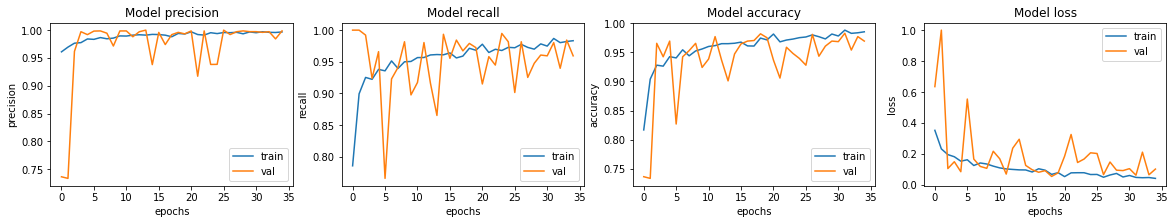

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

위에 epoch 돌릴 때 마다를 그래프로 모델의 precision, recall, accuracy, loss가 어떻게 변하는지 확인해 보자.

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 105ms/step - loss: 1.1084 - accuracy: 0.8301 - precision: 0.7996 - recall: 0.9718
Loss: 1.1083685159683228,
Accuracy: 0.8301281929016113,
Precision: 0.799578070640564,
Recall: 0.971794843673706


accuracy가 0.83정도 나오는데 이거 epoch값을 높혀도 비슷하게 나오는데,
어떻게 해야 오를 수 있을까..?
오늘 이 노드를 하면서 기본으로 이미지를 출력할 때 까지는 괜찮았는데 argumentation 이미지를 출력하려니까 머리가 터질 뻔했다.
어떻게 하는지 모르고 그냥 비슷하게 넣으면 되겠지 하는 생각에 시도했다가 차원이 늘어나서 고생했었다.
도움을 주신 박경은 퍼실님과 흥선님에게 감사인사를 드리고싶다.